In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv
/kaggle/input/siim-isic-melanoma-classification/train.csv
/kaggle/input/siim-isic-melanoma-classification/test.csv
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_2417927.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_0546632.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_2227618.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_7969975.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_3356592.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_8170270.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_2799021.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_4693305.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_3783148.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_9729657.jpg
/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_17

> **EffientNet**

In [2]:
!pip install -q efficientnet

> **Library import**

In [3]:
# Importing Necessary Libraries
%matplotlib inline
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
from collections import Counter
import efficientnet.tfkeras as efn
import re
from tensorflow.keras import layers as L
import sklearn

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

sns.set_style("dark")
sns.set(rc={'figure.figsize':(12,8)})

> **TPU detection**

In [4]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


> **Reading Dataset**

In [5]:
import pandas as pd
dataset = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
dataset

image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown           benign       0  
4                   upper extremity   unknown           benign       0  
...                             ...       ...              ...     ...  
33121                         torso   unknown           benign       0  
33122                         torso   unknown           benign       0  
33123               lower extremity   unknown           benign       0  
33124               lower extremity   unknown           benign       0  
33125                         torso     nevus           benign       0  

[33126 rows x 8 columns]

# **SIIM-ISIC Melanoma Classification**

# **Data Exploration**

In [6]:
dataset.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [7]:
dataset.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [8]:
dataset.describe()

age_approx        target
count  33058.000000  33126.000000
mean      48.870016      0.017630
std       14.380360      0.131603
min        0.000000      0.000000
25%       40.000000      0.000000
50%       50.000000      0.000000
75%       60.000000      0.000000
max       90.000000      1.000000

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [10]:
dataset.nunique()

image_name                       33126
patient_id                        2056
sex                                  2
age_approx                          18
anatom_site_general_challenge        6
diagnosis                            9
benign_malignant                     2
target                               2
dtype: int64

# **Data Visualisations**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='benign_malignant', ylabel='count'>

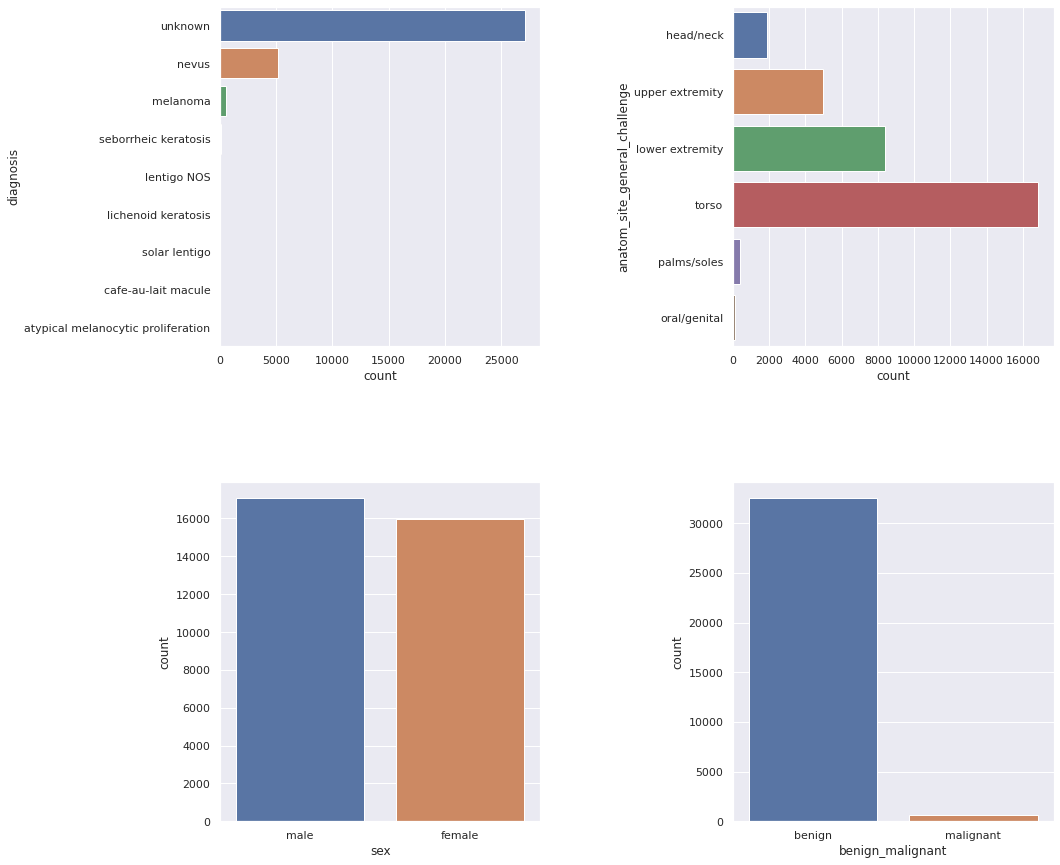

In [11]:
f, axes = plt.subplots(2, 2, figsize=(12,12))
f.tight_layout() 
plt.subplots_adjust(left=0.01, wspace=0.6, hspace=0.4)
sns.countplot(y="anatom_site_general_challenge", data=dataset,  ax=axes[0][1])
sns.countplot(y="diagnosis", data=dataset,  ax=axes[0][0])
sns.countplot(x='sex', data=dataset, ax=axes[1][0])
sns.countplot("benign_malignant", data=dataset,  ax=axes[1][1])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age_approx', ylabel='Density'>

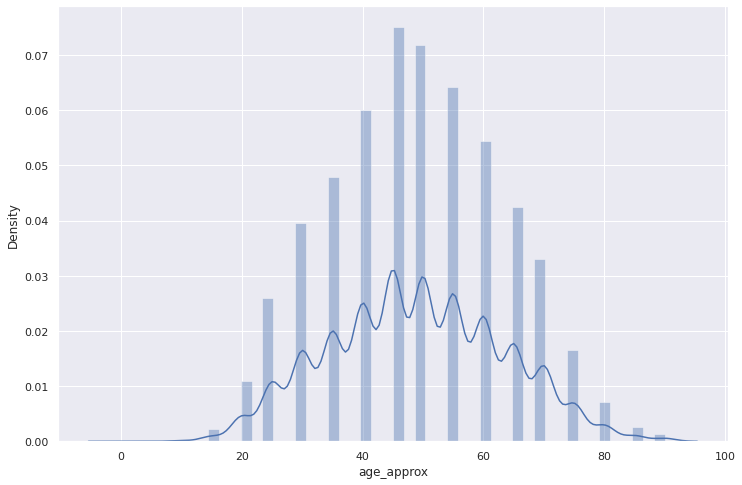

In [12]:
sns.distplot(dataset['age_approx'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

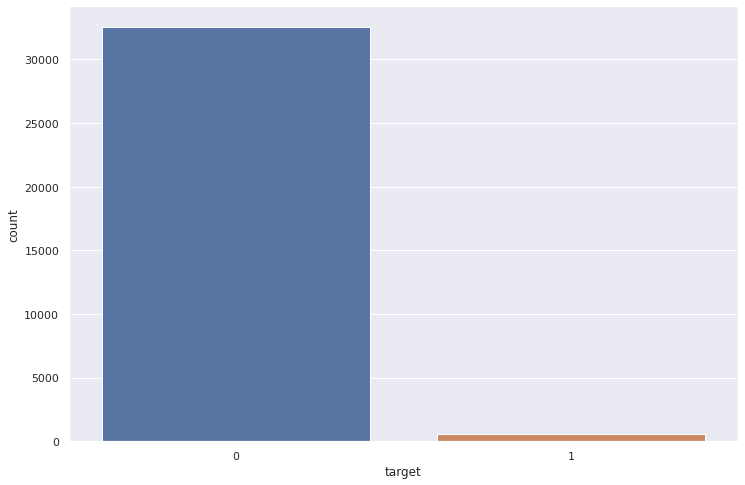

In [13]:
sns.countplot("target", data=dataset)

In [14]:
dataset['target'].value_counts(normalize=True) * 10

0    9.823703
1    0.176297
Name: target, dtype: float64

# **Images Visualisations**

> **Sample image**

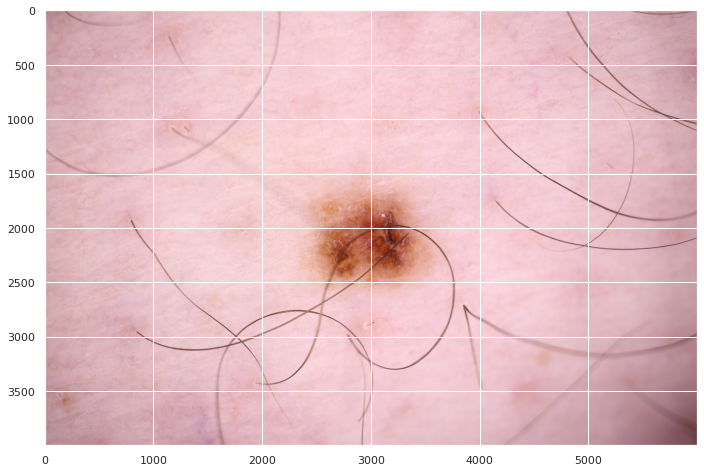

In [17]:
# Showing a sample image
image = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_5766923.jpg')
plt.imshow(image)

> **Sample benign**

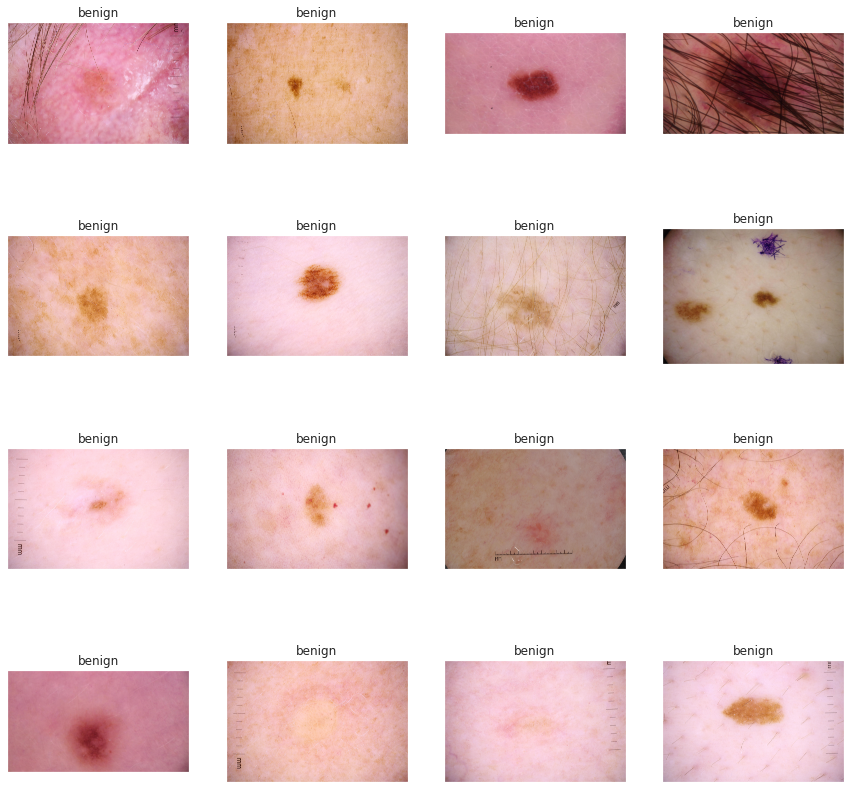

In [18]:
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+dataset.loc[dataset['target'] == 0]['image_name'].values[i]+'.jpg')
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    ax[-1].set_title(dataset.loc[dataset['target'] == 0]['benign_malignant'].values[i])   # set title
    plt.imshow(img)



plt.show()  # finally, render the plot

> **Sample malignant**

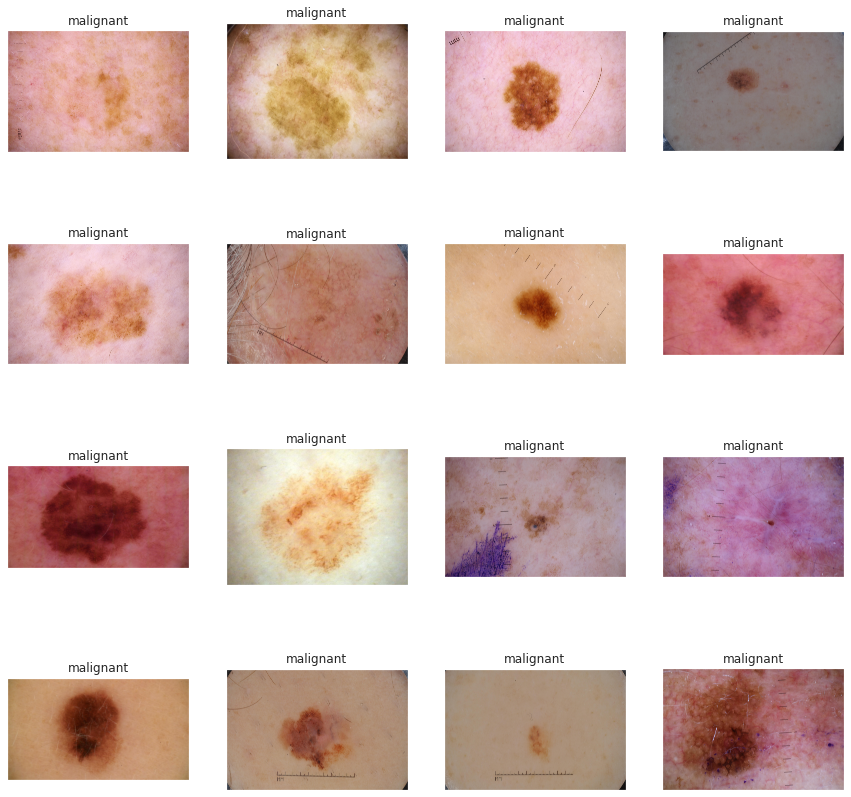

In [19]:
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = plt.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+dataset.loc[dataset['target'] == 1]['image_name'].values[i]+'.jpg')
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    # Hide grid lines
    ax[-1].grid(False)

    # Hide axes ticks
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    ax[-1].set_title(dataset.loc[dataset['target'] == 1]['benign_malignant'].values[i])  # set title
    plt.imshow(img)



plt.show()  # finally, render the plot

# **Cleaning Dataset**

>**Removing Null value**

In [20]:
dataset.isnull().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [21]:
dataset.loc[dataset.isnull().any(axis=1)]

image_name  patient_id     sex  age_approx  \
33     ISIC_0086462  IP_3200260  female        30.0   
38     ISIC_0088137  IP_5205991     NaN         NaN   
61     ISIC_0099474  IP_3057277    male        45.0   
188    ISIC_0174903  IP_2760044    male        40.0   
200    ISIC_0178744  IP_4248414    male        25.0   
...             ...         ...     ...         ...   
32898  ISIC_9928421  IP_0961415    male        45.0   
33001  ISIC_9963692  IP_6017204  female        35.0   
33025  ISIC_9971473  IP_1005683    male        70.0   
33041  ISIC_9975949  IP_9245079    male        40.0   
33112  ISIC_9997221  IP_6353955    male        55.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
33                              NaN   unknown           benign       0  
38                  lower extremity   unknown           benign       0  
61                              NaN   unknown           benign       0  
188                             NaN   unknown           benign       0  
200                             NaN   unknown           benign       0  
...                             ...       ...              ...     ...  
32898                           NaN   unknown           benign       0  
33001                           NaN   unknown           benign       0  
33025                           NaN   unknown           benign       0  
33041                           NaN     nevus           benign       0  
33112                           NaN   unknown           benign       0  

[595 rows x 8 columns]

In [23]:
dataset = dataset.dropna(axis=0)
dataset.isnull().sum()

In [24]:
dataset['target'].value_counts(normalize=True) * 10

0    9.823246
1    0.176754
Name: target, dtype: float64

In [25]:
dataset.nunique()

image_name                       32531
patient_id                        2051
sex                                  2
age_approx                          18
anatom_site_general_challenge        6
diagnosis                            9
benign_malignant                     2
target                               2
dtype: int64

# **Changing all column into categorical**

In [26]:
cleaned_dataset = dataset.copy()
cleaned_dataset

image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown           benign       0  
4                   upper extremity   unknown           benign       0  
...                             ...       ...              ...     ...  
33121                         torso   unknown           benign       0  
33122                         torso   unknown           benign       0  
33123               lower extremity   unknown           benign       0  
33124               lower extremity   unknown           benign       0  
33125                         torso     nevus           benign       0  

[32531 rows x 8 columns]

In [27]:
cleaned_dataset.sex = cleaned_dataset.sex.replace({'male':0, 'female':1})
cleaned_dataset = cleaned_dataset.join(pd.get_dummies(cleaned_dataset.anatom_site_general_challenge))
cleaned_dataset = cleaned_dataset.join(pd.get_dummies(cleaned_dataset.diagnosis))

In [28]:
pd.options.display.max_rows = 999
cleaned_dataset = cleaned_dataset.reset_index()
cleaned_dataset.head(35)

# **Creating the Training & Testing Dataset**

In [31]:
#For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

In [33]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')

CLASSES = [0,1]   
IMAGE_SIZE = [1024, 1024]
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

In [34]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
       
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images and {} unlabeled test images'.format(NUM_TRAINING_IMAGES,NUM_TEST_IMAGES))


Dataset: 33126 training images and 10982 unlabeled test images


In [39]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
EPOCHS = 10

In [40]:
def build_lrfn(lr_start=0.00001, lr_max=0.0001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [41]:
with strategy.scope():
    efficientnetb5_model = tf.keras.Sequential([
        efn.EfficientNetB5(
            input_shape=(*IMAGE_SIZE, 3),
            #weights='imagenet',
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation = 'relu'), 
        L.Dropout(0.3), 
        L.Dense(512, activation= 'relu'), 
        L.Dropout(0.2), 
        L.Dense(256, activation='relu'), 
        L.Dropout(0.2), 
        L.Dense(128, activation='relu'), 
        L.Dropout(0.1), 
        L.Dense(1, activation='sigmoid')
    ])

115515392/115515256 [==============================] - 1s 0us/step


In [42]:
from tensorflow.keras import backend as K

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [43]:
efficientnetb5_model.compile(
    optimizer='adam',
    loss = focal_loss(gamma=2., alpha=.25),
    #loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
    metrics=['binary_crossentropy', 'accuracy']
)
efficientnetb5_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 32, 32, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [ ]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [ ]:
history = efficientnetb5_model.fit(
    get_training_dataset(), 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_schedule],
    class_weight = {0:0.50899675,1: 28.28782609}
)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['binary_crossentropy'])
plt.title('model crossentropy')
plt.ylabel('crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
efficientnetb5_model.save('complete_data_efficient_modelte10.h5')

In [ ]:
efficientnetb5_model.save_weights('complete_data_efficient_weightste10.h5')